#### voynich manuscript analysis

In [2]:
import numpy as np
import re
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from collections import defaultdict
import random

In [4]:
!curl -O https://www.voynich.nu/data/IT2a-n.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  334k  100  334k    0     0   515k      0 --:--:-- --:--:-- --:--:--  515k


In [6]:
# Example: "clean_ivtff.py"
clean_lines = []
with open('IT2a-n.txt', 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        # Skip empty or comment lines
        if not line or line.startswith('#'):
            continue
        
        # If line starts with <...>, remove that piece
        # e.g., "<f1r.1,@P0>       <%>fachys.ykal..." -> "      <%>fachys.ykal..."
        # This simple approach finds the first space and slices; adjust as needed
        if line.startswith('<'):
            first_space_idx = line.find(' ')
            if first_space_idx != -1:
                line = line[first_space_idx:].strip()
        
        # Remove any remaining bracketed tags if you don't want them
        # e.g., remove "<%>" or "<! ...>"
        import re
        line = re.sub(r'<.*?>', '', line).strip()
        
        # If there's still something left, keep it
        if line:
            clean_lines.append(line)

# Now 'clean_lines' should mostly contain just Voynich text.
clean_text = "\n".join(clean_lines)

with open('data/voynich_char/clean_taka.txt', 'w', encoding='utf-8') as f:
    f.write(clean_text)


In [7]:
len(clean_text)

228845

In [8]:
clean_text[0:1000]

'fachys.ykal.ar.ataiin.shol.shory.cthres.y.kor.sholdy\nsory.ckhar.or.y.kair.chtaiin.shar.are.cthar.cthar.dan\nsyaiir.sheky.or.ykaiin.shod.cthoary.cthes.daraiin.sa\nooiin.oteey.oteos.roloty.cth?ar.daiin.otaiin.or.okan\ndair.y.chear.cthaiin.cphar.cfhaiin\nydaraishy\n?.odar.o.y.shol.cphoy.oydar.sh.s.cfhoaiin.shodary\nyshey.shody.okchoy.otchol.chocthy.oschy.dain.chor.kos\ndaiin.shos.cfhol.shody\ndain.os.teody\n?.ydain.cphesaiin.ol.s.cphey.ytain.shoshy.cphodales\noksho.kshoy.otairin.oteol.okan.shodain.sckhey.daiin\nshoy.ckhey.kodaiin.cphy.cphodaiils.cthey.she.oldain.d\ndain.oiin.chol.odaiin.chodain.chdy.okain.dan.cthy.kod\ndaiin.shckhey.ckeor.chor.shey.kol.chol.chol.kor.chal\nsho.chol.shodan.kshy.kchy.dor.chodaiin.sho.kchom\nycho.tchey.chokain.sheo.pshol.dydyd.cthy.daicthy\nyto.shol.she.kodshey.cphealy.dasain.dain.ckhyds\ndchar.shcthaiin.okaiir.chey.rchy.potol.cthols.dlocta\nshok.chor.chey.dain.ckhey\notol.daiiin\ncpho.shaiin.shokcheey.chol.tshodeesy.shey.pydeey.chy.ro.d?\n?doin.chol.dain.c

In [9]:
# Step 1: Load cleaned text
with open("data/voynich_char/clean_taka.txt", "r", encoding="utf-8") as f:
    clean_text = f.read()

# Step 2: Split text into lines and then into words using '.' as the delimiter.
# Newlines are preserved as line breaks.
lines = clean_text.splitlines()
words = []
for line in lines:
    # Split on period, stripping extra whitespace and ignoring empty tokens.
    tokens = [token.strip() for token in line.split('.') if token.strip()]
    words.extend(tokens)

print("Total words:", len(words))

# Step 3: Extract n-grams for n = 1 to 5 from each word (n-grams do not cross word boundaries)
def extract_ngrams(word, n):
    """Extract all contiguous n-grams of length n from a given word."""
    return [word[i:i+n] for i in range(len(word) - n + 1)]

ngram_counter = Counter()
ngrams_by_word = []  # optionally store per-word n-gram dictionaries

for word in words:
    word_ngrams = {}
    for n in range(1, 6):
        if len(word) >= n:
            ngrams = extract_ngrams(word, n)
            word_ngrams[n] = ngrams
            ngram_counter.update(ngrams)
        else:
            word_ngrams[n] = []
    ngrams_by_word.append(word_ngrams)

print("Total unique n-grams (n=1 to 5):", len(ngram_counter))

# Step 4: Filter out extremely rare n-grams (e.g., frequency less than or equal to a threshold)
threshold = 2  # adjust threshold as needed (here, we keep n-grams that occur > 2 times)
filtered_ngrams = {ngram: count for ngram, count in ngram_counter.items() if count > threshold}
print("Unique n-grams after filtering (freq > {}): {}".format(threshold, len(filtered_ngrams)))

# Step 5 (Optional): Compute co-occurrence statistics within words
# Here we count, for each n-gram, how often it appears with other n-grams in the same word.
cooccurrence = defaultdict(Counter)
for word in words:
    # Gather all n-grams (across n=1 to 5) for this word
    word_all_ngrams = []
    for n in range(1, 6):
        if len(word) >= n:
            word_all_ngrams.extend(extract_ngrams(word, n))
    unique_ngrams = set(word_all_ngrams)
    for ngram1 in unique_ngrams:
        for ngram2 in unique_ngrams:
            if ngram1 != ngram2:
                cooccurrence[ngram1][ngram2] += 1

# Step 6 (Optional): Compute simple feature representations for each filtered n-gram.
# Here we use a normalized ASCII histogram as a basic feature vector.
def ngram_features(ngram):
    features = np.zeros(128)  # using an array for ASCII characters 0-127
    for char in ngram:
        ascii_val = ord(char)
        if ascii_val < 128:
            features[ascii_val] += 1
    if features.sum() > 0:
        features /= features.sum()
    return features

ngram_features_dict = {}
for ngram in filtered_ngrams:
    ngram_features_dict[ngram] = ngram_features(ngram)

print("Computed feature vectors for clustering of n-grams (optional).")

# Optionally, you can now use clustering (e.g., KMeans) on the feature matrix constructed from ngram_features_dict.

X = np.array(list(ngram_features_dict.values()))
kmeans = KMeans(n_clusters=50, random_state=42).fit(X)
#examine the clusters and see if they correlate with known subject areas.

print("Data preparation and n-gram extraction complete.")


Total words: 37044
Total unique n-grams (n=1 to 5): 14895
Unique n-grams after filtering (freq > 2): 5372
Computed feature vectors for clustering of n-grams (optional).
Data preparation and n-gram extraction complete.


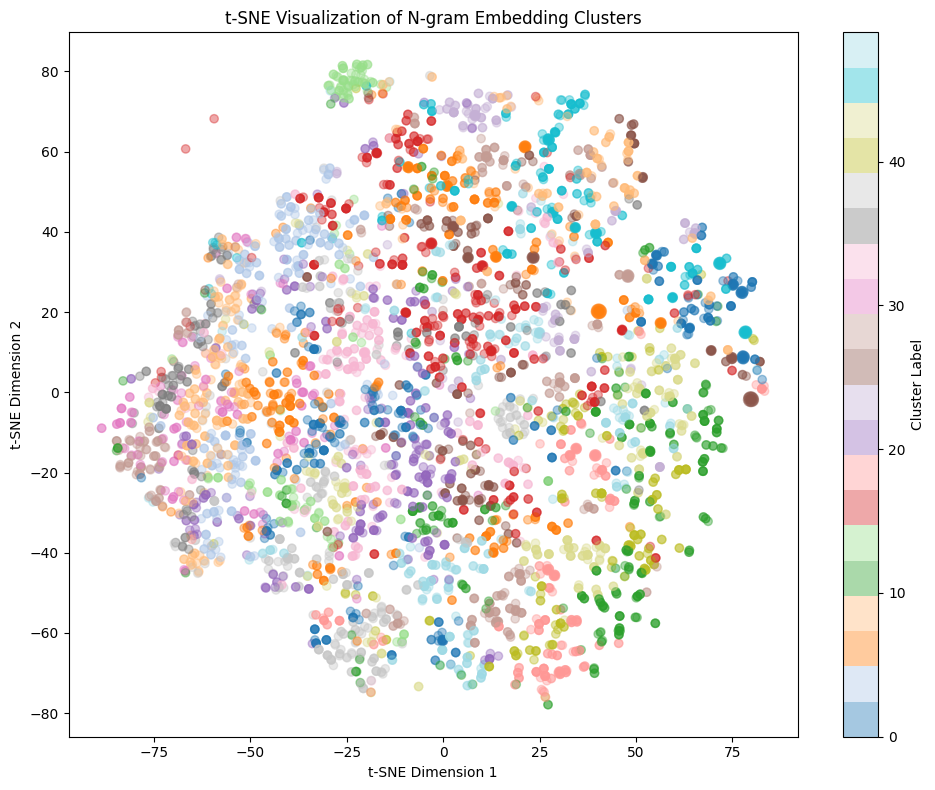

Representative n-grams per cluster (ordered by frequency):

Cluster 0: r, or, hor, ro, okar
Cluster 1: che, ched, chee, ec, pche
Cluster 2: heol, lke, olke, keol, lked
Cluster 3: q, okai, qokai, otai, okain
Cluster 4: ha, cha, hda, cheda, chda
Cluster 5: k, ky, yk, oky, yka
Cluster 6: a, ar, dar, ra, tar
Cluster 7: cho, cheo, oc, otc, otch
Cluster 8: h, ch, chd, hc, chc
Cluster 9: ai, dai, daii, kaii, tai
Cluster 10: e, ee, kee, eey, eed
Cluster 11: he, hey, hee, heey, shee
Cluster 12: t, ot, qot, to, oto
Cluster 13: ta, ota, tal, qota, otal
Cluster 14: ?, ??, ???, ????, ?o
Cluster 15: hol, chol, lc, lch, lche
Cluster 16: ho, sho, os, sheo, so
Cluster 17: y, yt, ly, ty, yp
Cluster 18: eeo, oee, eeod, heeo, eeor
Cluster 19: ke, oke, qoke, okee, qokee
Cluster 20: dal, ld, ldy, old, dol
Cluster 21: o, ol, qo, lo, op
Cluster 22: ka, kai, kar, lkai, kair
Cluster 23: hy, khy, shy, ksh, ys
Cluster 24: f, fc, fch, fche, fh
Cluster 25: ody, oty, hody, oly, oy
Cluster 26: c, kc, kch, kh, ck
Clus

In [14]:
# Assuming that 'X', 'filtered_ngrams', and 'kmeans' have been computed as in the previous cell.
# X is the feature matrix (rows = n-grams, columns = 128 (ASCII histogram))
# kmeans.labels_ gives the cluster assignment for each n-gram in X.
# filtered_ngrams is a dict mapping n-grams to their frequency counts.

# Reduce the 128-dimensional feature space to 2 dimensions using t-SNE.
tsne = TSNE(n_components=2, random_state=42, init='pca', perplexity=30)
X_tsne = tsne.fit_transform(X)

# Retrieve the cluster labels from kmeans.
cluster_labels = kmeans.labels_

# Plot the t-SNE scatter plot of n-gram features, color-coded by cluster label.
plt.figure(figsize=(10, 8))
sc = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='tab20', alpha=0.4)
plt.colorbar(sc, label='Cluster Label')
plt.title('t-SNE Visualization of N-gram Embedding Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.tight_layout()
plt.show()

# Build a mapping from cluster label to the list of n-grams in that cluster.
cluster_to_ngrams = defaultdict(list)
for ngram, label in zip(ngram_features_dict.keys(), cluster_labels):
    cluster_to_ngrams[label].append(ngram)

# Print out representative examples from each cluster.
print("Representative n-grams per cluster (ordered by frequency):\n")
for label in sorted(cluster_to_ngrams):
    # Sort the n-grams in the cluster by their frequency in descending order.
    sorted_ngrams = sorted(cluster_to_ngrams[label], key=lambda ng: filtered_ngrams.get(ng, 0), reverse=True)
    # Limit the output to the top 5 n-grams for brevity.
    examples = sorted_ngrams[:5]
    print(f"Cluster {label}: {', '.join(examples)}")


shuffle the words

In [19]:
# --- Step 1: Load cleaned text ---
with open("clean_taka.txt", "r", encoding="utf-8") as f:
    clean_text = f.read()

# --- Step 2: Split text into lines and then into words using '.' as delimiter ---
# Newlines are preserved as line breaks, but we treat each period-separated token as a "word"
lines = clean_text.splitlines()
words = []
for line in lines:
    # Split on period, stripping extra whitespace and ignoring empty tokens.
    tokens = [token.strip() for token in line.split('.') if token.strip()]
    words.extend(tokens)

print("Total words (before shuffling):", len(words))

# --- Shuffle the words ---
random.shuffle(words)
print("Words have been shuffled.")

# --- Step 3: Extract word-level n-grams (n = 1 to 5) ---
def extract_word_ngrams(word_list, n):
    """
    Extract all contiguous n-grams from a list of words.
    Each n-gram is represented as a tuple of words.
    """
    return [tuple(word_list[i:i+n]) for i in range(len(word_list) - n + 1)]

# We'll compute and count n-grams at the word level.
word_ngram_counter = Counter()
for n in range(1, 6):
    ngrams = extract_word_ngrams(words, n)
    word_ngram_counter.update(ngrams)
    print(f"Total unique {n}-grams:", len(set(ngrams)))

# --- Step 4: Filter out extremely rare n-grams ---
threshold = 2  # adjust as needed; here we keep n-grams that occur more than 2 times.
filtered_word_ngrams = {ngram: count for ngram, count in word_ngram_counter.items() if count > threshold}
print("Unique word n-grams after filtering (freq > {}): {}".format(threshold, len(filtered_word_ngrams)))

# --- Step 5 (Optional): Co-occurrence statistics or feature extraction ---
# (For word-level n-grams in a shuffled order, you might simply compare frequency distributions.
#  If desired, you could build feature representations, e.g., based on average word lengths,
#  letter histograms for the concatenated words, etc.)

print("Data preparation and word-level n-gram extraction complete.")

Total words (before shuffling): 37044
Words have been shuffled.
Total unique 1-grams: 8550
Total unique 2-grams: 33796
Total unique 3-grams: 37014
Total unique 4-grams: 37041
Total unique 5-grams: 37040
Unique word n-grams after filtering (freq > 2): 2158
Data preparation and word-level n-gram extraction complete.


Computed feature vectors for word-level n-grams.


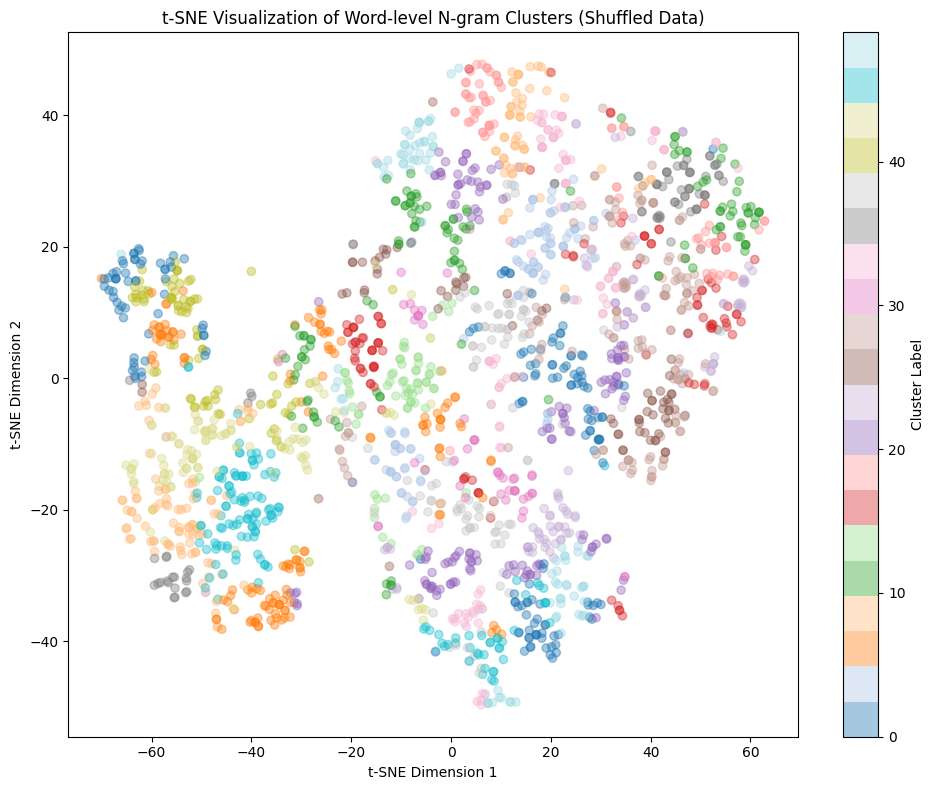

Representative word-level n-grams per cluster (ordered by frequency):

Cluster 0: okedy, okeedy, okey, ykeey, keedy
Cluster 1: chaiin, shaiin, chkaiin, chain, chokaiin
Cluster 2: sho, shor, shody, sheor, sheody
Cluster 3: olchedy, olchey, ycheol, qolchey, qolchedy
Cluster 4: or, dor, sor, lor, otor
Cluster 5: ar, dar, r, kar, tar
Cluster 6: ol, qol, dol, qokol, otol
Cluster 7: shedaiin, daiin shedy, shedain, shedy daiin, oteodaiin
Cluster 8: chol, cheol, cheo, cho, cthol
Cluster 9: aiin, okaiin, otaiin, saiin, ain
Cluster 10: otar, qotar, odar, oar, arody
Cluster 11: chedal, chedy ar, chedam, ar chedy, cheedar
Cluster 12: chdy, chy, chckhy, chcthy, shckhy
Cluster 13: al, dal, sal, aly, kal
Cluster 14: qokal, otal, okal, qotal, okaly
Cluster 15: chey, cheey, cheedy, lchey, ycheey
Cluster 16: oky, ky, olky, yky, lky
Cluster 17: lkar, olkar, ral, aral, lr
Cluster 18: chor, cheor, cthor, dchor, kchor
Cluster 19: opchey, ykchy, cphy, opchy, ychey
Cluster 20: chal, cheal, chl, chdal, chkal
C

In [20]:


# Compute feature representations for each word-level n-gram.
# Each n-gram (a tuple of words) is joined into a single string, and we compute a normalized ASCII histogram.
def word_ngram_features(ngram_tuple):
    s = " ".join(ngram_tuple)  # join words with a space
    features = np.zeros(128)   # use ASCII range 0-127
    for char in s:
        ascii_val = ord(char)
        if ascii_val < 128:
            features[ascii_val] += 1
    if features.sum() > 0:
        features /= features.sum()
    return features

# Build a dictionary of feature vectors for each filtered word-level n-gram.
word_ngram_features_dict = {}
for ngram, count in filtered_word_ngrams.items():
    word_ngram_features_dict[ngram] = word_ngram_features(ngram)

print("Computed feature vectors for word-level n-grams.")

# Build the feature matrix X. We keep a list of the n-gram keys to preserve ordering.
ngram_keys = list(word_ngram_features_dict.keys())
X = np.array([word_ngram_features_dict[k] for k in ngram_keys])

# Cluster using KMeans (for example, into 50 clusters)
kmeans = KMeans(n_clusters=50, random_state=42).fit(X)
cluster_labels = kmeans.labels_

# Reduce the 128-dimensional feature space to 2 dimensions using t-SNE.
tsne = TSNE(n_components=2, random_state=42, init='pca', perplexity=30)
X_tsne = tsne.fit_transform(X)

# Plot the t-SNE scatter plot of word-level n-gram features, color-coded by cluster label.
plt.figure(figsize=(10, 8))
sc = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='tab20', alpha=0.4)
plt.colorbar(sc, label='Cluster Label')
plt.title('t-SNE Visualization of Word-level N-gram Clusters (Shuffled Data)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.tight_layout()
plt.show()

# Build a mapping from cluster label to the list of n-grams (as strings) in that cluster.
cluster_to_ngrams = defaultdict(list)
for ngram, label in zip(ngram_keys, cluster_labels):
    # Convert tuple to a single string (words separated by space)
    ngram_str = " ".join(ngram)
    cluster_to_ngrams[label].append(ngram_str)

# Print out representative examples from each cluster.
print("Representative word-level n-grams per cluster (ordered by frequency):\n")
for label in sorted(cluster_to_ngrams):
    # Sort the n-grams in the cluster by their frequency in descending order.
    sorted_ngrams = sorted(cluster_to_ngrams[label],
                           key=lambda ng: filtered_word_ngrams.get(tuple(ng.split()), 0),
                           reverse=True)
    # Limit to top 5 examples for brevity.
    examples = sorted_ngrams[:5]
    print(f"Cluster {label}: {', '.join(examples)}")


In [28]:
# Step 1: Load cleaned text
with open("data/capote_char/clean_incoldblood.txt", "r", encoding="utf-8") as f:
    clean_text = f.read()
# Clip to match Voynich size (228845 characters)
voynichSize=228845
clean_text = clean_text[:voynichSize]

# Step 2: Split text into lines and then into words using whitespace as the delimiter.
# Newlines are preserved as line breaks.
lines = clean_text.splitlines()
words = []
for line in lines:
    # Split on whitespace (default behavior of split())
    tokens = line.split()
    words.extend(tokens)
print("Total words:", len(words))

# Step 3: Extract n-grams for n = 1 to 5 from each word (n-grams do not cross word boundaries)
def extract_ngrams(word, n):
    """Extract all contiguous n-grams of length n from a given word."""
    return [word[i:i+n] for i in range(len(word) - n + 1)]

ngram_counter = Counter()
ngrams_by_word = []  # optionally store per-word n-gram dictionaries

for word in words:
    word_ngrams = {}
    for n in range(1, 6):
        if len(word) >= n:
            ngrams = extract_ngrams(word, n)
            word_ngrams[n] = ngrams
            ngram_counter.update(ngrams)
        else:
            word_ngrams[n] = []
    ngrams_by_word.append(word_ngrams)

print("Total unique n-grams (n=1 to 5):", len(ngram_counter))

# Step 4: Filter out extremely rare n-grams (e.g., frequency less than or equal to a threshold)
threshold = 2  # adjust threshold as needed (here, we keep n-grams that occur > 2 times)
filtered_ngrams = {ngram: count for ngram, count in ngram_counter.items() if count > threshold}
print("Unique n-grams after filtering (freq > {}): {}".format(threshold, len(filtered_ngrams)))

# Step 5 (Optional): Compute co-occurrence statistics within words
# Here we count, for each n-gram, how often it appears with other n-grams in the same word.
cooccurrence = defaultdict(Counter)
for word in words:
    # Gather all n-grams (across n=1 to 5) for this word
    word_all_ngrams = []
    for n in range(1, 6):
        if len(word) >= n:
            word_all_ngrams.extend(extract_ngrams(word, n))
    unique_ngrams = set(word_all_ngrams)
    for ngram1 in unique_ngrams:
        for ngram2 in unique_ngrams:
            if ngram1 != ngram2:
                cooccurrence[ngram1][ngram2] += 1

# Step 6 (Optional): Compute simple feature representations for each filtered n-gram.
# Here we use a normalized ASCII histogram as a basic feature vector.
def ngram_features(ngram):
    features = np.zeros(128)  # using an array for ASCII characters 0-127
    for char in ngram:
        ascii_val = ord(char)
        if ascii_val < 128:
            features[ascii_val] += 1
    if features.sum() > 0:
        features /= features.sum()
    return features

ngram_features_dict = {}
for ngram in filtered_ngrams:
    ngram_features_dict[ngram] = ngram_features(ngram)

print("Computed feature vectors for clustering of n-grams (optional).")

# Optionally, you can now use clustering (e.g., KMeans) on the feature matrix constructed from ngram_features_dict.

X = np.array(list(ngram_features_dict.values()))
kmeans = KMeans(n_clusters=50, random_state=42).fit(X)
#examine the clusters and see if they correlate with known subject areas.

print("Data preparation and n-gram extraction complete.")


Total words: 39753
Total unique n-grams (n=1 to 5): 40304
Unique n-grams after filtering (freq > 2): 14985
Computed feature vectors for clustering of n-grams (optional).
Data preparation and n-gram extraction complete.


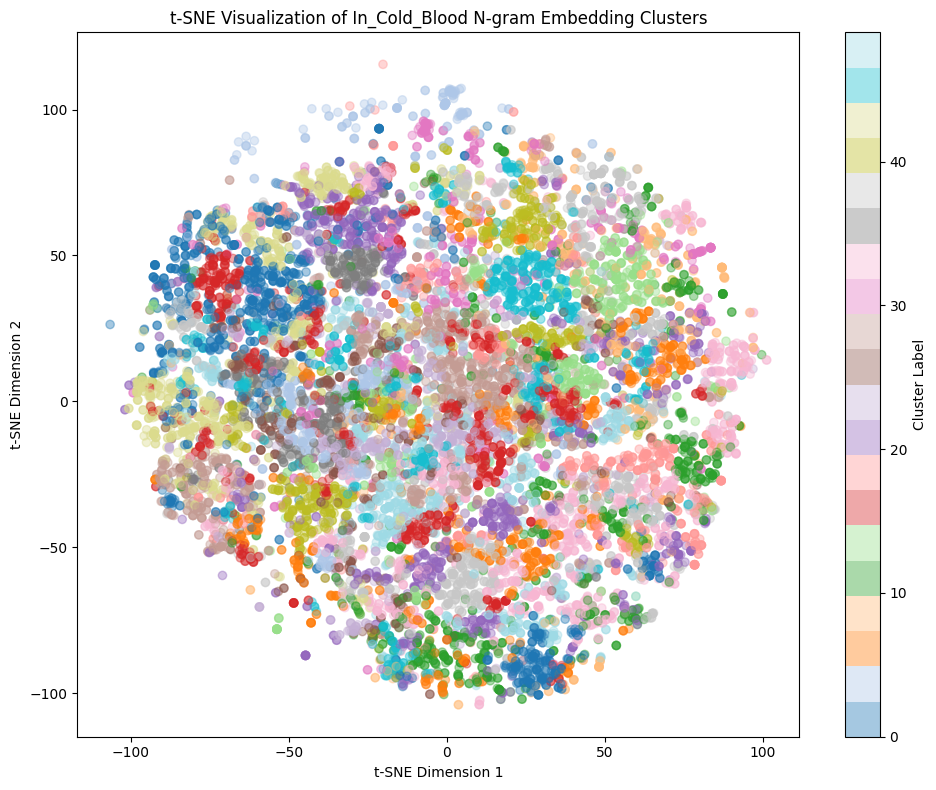

Representative n-grams per cluster (ordered by frequency):

Cluster 0: o, ho, co, ow, oo
Cluster 1: r, or, ro, for, rr
Cluster 2: ng, ing, ig, igh, hing
Cluster 3: w, ,, ’, “, ”
Cluster 4: ur, rt, tr, ru, ure
Cluster 5: is, si, sai, said, ist
Cluster 6: m, me, ma, im, em
Cluster 7: nt, ent, n’t, nte, ten
Cluster 8: e, ea, we, ee, e,
Cluster 9: g, gh, ge, ug, ugh
Cluster 10: his, side, ish, ise, ies
Cluster 11: i, in, hi, wi, ni
Cluster 12: d, ed, nd, ad, de
Cluster 13: f, of, fo, fi, fa
Cluster 14: te, ter, et, tte, ted
Cluster 15: ol, lo, oul, ould, old
Cluster 16: as, was, sa, sta, ast
Cluster 17: ns, ans, nds, san, ngs
Cluster 18: p, pe, pr, pa, pl
Cluster 19: ie, ei, ike, ite, time
Cluster 20: n, en, ne, n,, n’
Cluster 21: other, ore, ose, ouse, over
Cluster 22: ri, ir, rin, air, ari
Cluster 23: l, al, ll, la, ld
Cluster 24: k, ck, ick, Dick, ak
Cluster 25: bu, but, bou, ub, bout
Cluster 26: c, ic, ch, ce, ca
Cluster 27: y, ly, ay, ry, y,
Cluster 28: ar, ra, ear, rea, ard
Cluster 2

In [29]:
# Assuming that 'X', 'filtered_ngrams', and 'kmeans' have been computed as in the previous cell.
# X is the feature matrix (rows = n-grams, columns = 128 (ASCII histogram))
# kmeans.labels_ gives the cluster assignment for each n-gram in X.
# filtered_ngrams is a dict mapping n-grams to their frequency counts.

# Reduce the 128-dimensional feature space to 2 dimensions using t-SNE.
tsne = TSNE(n_components=2, random_state=42, init='pca', perplexity=30)
X_tsne = tsne.fit_transform(X)

# Retrieve the cluster labels from kmeans.
cluster_labels = kmeans.labels_

# Plot the t-SNE scatter plot of n-gram features, color-coded by cluster label.
plt.figure(figsize=(10, 8))
sc = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='tab20', alpha=0.4)
plt.colorbar(sc, label='Cluster Label')
plt.title('t-SNE Visualization of In_Cold_Blood N-gram Embedding Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.tight_layout()
plt.show()

# Build a mapping from cluster label to the list of n-grams in that cluster.
cluster_to_ngrams = defaultdict(list)
for ngram, label in zip(ngram_features_dict.keys(), cluster_labels):
    cluster_to_ngrams[label].append(ngram)

# Print out representative examples from each cluster.
print("Representative n-grams per cluster (ordered by frequency):\n")
for label in sorted(cluster_to_ngrams):
    # Sort the n-grams in the cluster by their frequency in descending order.
    sorted_ngrams = sorted(cluster_to_ngrams[label], key=lambda ng: filtered_ngrams.get(ng, 0), reverse=True)
    # Limit the output to the top 5 n-grams for brevity.
    examples = sorted_ngrams[:5]
    print(f"Cluster {label}: {', '.join(examples)}")


In [30]:
words

['The',
 'village',
 'of',
 'Holcomb',
 'stands',
 'on',
 'the',
 'high',
 'wheat',
 'plains',
 'of',
 'western',
 'Kansas,',
 'a',
 'lonesome',
 'area',
 'that',
 'other',
 'Kansans',
 'call',
 '“out',
 'there.”',
 'Some',
 'seventy',
 'miles',
 'east',
 'of',
 'the',
 'Colorado',
 'border,',
 'the',
 'countryside,',
 'with',
 'its',
 'hard',
 'blue',
 'skies',
 'and',
 'desert-',
 'clear',
 'air,',
 'has',
 'an',
 'atmosphere',
 'that',
 'is',
 'rather',
 'more',
 'Far',
 'West',
 'than',
 'Middle',
 'West.',
 'The',
 'local',
 'accent',
 'is',
 'barbed',
 'with',
 'a',
 'prairie',
 'twang,',
 'a',
 'ranch-hand',
 'nasalness,',
 'and',
 'the',
 'men,',
 'many',
 'of',
 'them,',
 'wear',
 'narrow',
 'frontier',
 'trousers,',
 'Stetsons,',
 'and',
 'high-',
 'heeled',
 'boots',
 'with',
 'pointed',
 'toes.',
 'The',
 'land',
 'is',
 'flat,',
 'and',
 'the',
 'views',
 'are',
 'awesomely',
 'extensive;',
 'horses,',
 'herds',
 'of',
 'cattle,',
 'a',
 'white',
 'cluster',
 'of',
 'grain